In [1]:
! pip install tf-agents
! pip install pyvirtualdisplay
! sudo apt-get install -y xvfb ffmpeg
! pip install 'imageio==2.4.0'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [19]:
from tf_agents.environments import suite_gym
import numpy as np

env_name = 'CartPole-v0'

env = suite_gym.load(env_name)

In [20]:
print(env.reset())

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.00899942, -0.03945892,  0.04241252, -0.02644956], dtype=float32))


In [21]:
import pandas as pd

# create an empty dataframe
df = pd.DataFrame(columns=['step_type', 'reward', 'discount', 'observation'])

# initial state
time_step = env.reset()
df = df.append(
    {
    'step_type': time_step.step_type, 
    'reward': time_step.reward, 
    'discount': time_step.discount, 
    'observation': time_step.observation
    }, 
    ignore_index=True
)

# iterate while the time_step is not the last
while not time_step.is_last():
    time_step = env.step(np.array([1]))
    df = df.append(
        {
        'step_type': time_step.step_type, 
        'reward': time_step.reward, 
        'discount': time_step.discount, 
        'observation': time_step.observation
        }, 
        ignore_index=True
    )

In [22]:
df

,step_type,reward,discount,observation
0,0,0.0,1.0,"[0.0061636674, -0.02724263, -0.019950338, -0.0..."
1,1,1.0,1.0,"[0.005618815, 0.16815968, -0.020006528, -0.301..."
2,1,1.0,1.0,"[0.008982008, 0.36356097, -0.026040921, -0.600..."
3,1,1.0,1.0,"[0.016253227, 0.5590373, -0.03805381, -0.90141..."
4,1,1.0,1.0,"[0.027433975, 0.75465363, -0.056082107, -1.205..."
5,1,1.0,1.0,"[0.042527046, 0.9504537, -0.08019834, -1.5155298]"
6,1,1.0,1.0,"[0.061536122, 1.1464493, -0.11050894, -1.8321313]"
7,1,1.0,1.0,"[0.08446511, 1.3426075, -0.14715156, -2.1569972]"
8,1,1.0,1.0,"[0.11131726, 1.5388353, -0.19029151, -2.4912646]"
9,2,1.0,0.0,"[0.14209397, 1.7349622, -0.2401168, -2.8357532]"


In [23]:
from tf_agents.environments import tf_py_environment

# two environments, one for training and one for evaluation
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [24]:
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network
from tf_agents.utils import common

# fully connected layer architecture
fc_layer_params = (100, )

# defining q network using train_env and fully connected layer architecture
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params
)

learning_rate=0.001

# adam optimizer to do the training
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

# create agent using the network, specifications, and other parameters
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter

)

# initialize the agent
agent.initialize()

In [25]:
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

# eval_policy for evaluation and collect_policy for collection
eval_policy = agent.policy
collect_policy = agent.collect_policy

# random policy -- select action from the list of actions randomly
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

replay_buffer_max_length=100000

# utility function to compute average return
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return
        
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

# replay buffer to collect the trajectories
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length
)

# functions to collect data to the replay buffer
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)
    
def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)
        
collect_data(train_env, random_policy, replay_buffer, steps=100)

In [26]:
batch_size=64

dataset = replay_buffer.as_dataset(
  num_parallel_calls=3, 
  sample_batch_size=batch_size, 
  num_steps=2
).prefetch(3)
iterator = iter(dataset)

In [27]:
num_iterations = 20000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000
batch_size = 64
learning_rate = 1e-3
log_interval = 200
num_eval_episodes = 10
eval_interval = 1000

In [28]:
from tf_agents.utils import common

# Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# reset the train step
agent.train_step_counter.assign(0)

# evaluate the agent's policy once before training
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):
  
    # collect few experiences using collect policy and store in the replay buffer    
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)
        
    # take a batch of data from the replay buffer and train the network
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    
    step = agent.train_step_counter.numpy()
    
    if step % log_interval == 0:
        print('Step = {}: Loss = {}'.format(step, train_loss))
        
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('Step = {}: Average Return ={}'.format(step, avg_return))
        returns.append(avg_return)

Step = 200: Loss = 6.8906683921813965
Step = 400: Loss = 39.86635971069336
Step = 600: Loss = 22.01109504699707
Step = 800: Loss = 41.67791748046875
Step = 1000: Loss = 27.92828369140625
Step = 1000: Average Return =115.80000305175781
Step = 1200: Loss = 64.84320068359375
Step = 1400: Loss = 29.111461639404297
Step = 1600: Loss = 112.30945587158203
Step = 1800: Loss = 99.80864715576172
Step = 2000: Loss = 94.21883392333984
Step = 2000: Average Return =20.799999237060547
Step = 2200: Loss = 42.40301513671875
Step = 2400: Loss = 31.083816528320312
Step = 2600: Loss = 33.547454833984375
Step = 2800: Loss = 134.81649780273438
Step = 3000: Loss = 43.32163619995117
Step = 3000: Average Return =22.100000381469727
Step = 3200: Loss = 57.239479064941406
Step = 3400: Loss = 14.82436752319336
Step = 3600: Loss = 31.511682510375977
Step = 3800: Loss = 69.3167724609375
Step = 4000: Loss = 13.505757331848145
Step = 4000: Average Return =115.9000015258789
Step = 4200: Loss = 13.812108039855957
Step =

(-0.025000000000000355, 220.0)

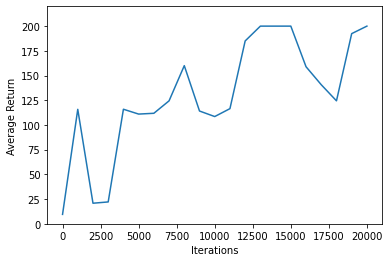

In [29]:
import matplotlib.pyplot as plt

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=220)

In [30]:
import pyvirtualdisplay

display = pyvirtualdisplay.Display(visible=False, size=(1400, 900)).start()

In [31]:
import base64
import imageio
import IPython

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [32]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")